<a href="https://colab.research.google.com/github/pejmanrasti/FormationUnivAngers/blob/main/Jour3/Segmentation_Digitail_Plant_Phenotyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentation: DIGITAL PLANT PHENOTYPING**

Here we will use RGB images of *Arabidopsis thaliana* in order to train a CNN model that is able to segment all plant leaves even if there is leaf occlusions. 

The challenge is to use the trained model for the same task but in different imaging modality namely in chlorophyll fluorescence imaging. Our test images are 38 gray-scale noisy images of fluorescent quantum efficiency. 

Your goal is to find an effecient transfer learning strategy that allows us to use RGB images for leaf segmentation on fluorescent images.

#**Setting environnement: libraries, parameters, functions**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/ggdrive')

Mounted at /content/ggdrive


## Importing necessary libraries


In [ ]:
import cv2
import os
import shutil
import sys
import random
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.morphology import label, watershed, disk, remove_small_objects, dilation, square, closing, erosion, opening
from scipy import ndimage as ndi
from skimage import color, feature, restoration, measure

from skimage.filters import rank, sobel
from skimage.transform import resize
from skimage.feature import canny, peak_local_max

from skimage.color import label2rgb
from skimage.util import img_as_ubyte, random_noise

from keras.optimizers import Adam, RMSprop
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda, Reshape, Permute, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [ ]:
%matplotlib inline

In [ ]:
from IPython.display import display, HTML 

from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion,                              
                            ElasticTransform, JpegCompression, HueSaturationValue, GridDistortion,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, 
                            InvertImg, RandomGamma, ToGray, PadIfNeeded, RandomCrop, Compose, Transpose, RandomSizedCrop, OneOf, Normalize)

##Set some parameters

### Image parameters

In [ ]:
# you need to set up a numerical value here. Useful to resize to normalize data size
IMG_WIDTH = 128
IMG_HEIGHT = 128
# number of image/labels channels
IMG_CHANNELS = 3
LABEL_CHANNELS = 3

seed = 42
random.seed = seed
np.random.seed = seed

### Folders for reading data

In [ ]:
DATADIR = '/content/ggdrive/My Drive/Deep Learning Book/Data'
TRAIN_PATH = '/content/ggdrive/My Drive/Data/LSC_training'
TEST_PATH = '/content/ggdrive/My Drive/Data/LSC_test'

## Functions 

### Getting three-channel binary labels from ground-truth labels 

In [ ]:
import argparse
import glob
 
def auto_canny(image, sigma=0.01):
    # compute the median of the single channel pixel intensities
    image = image*255
    image = image.astype(np.uint8)
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
  
    # return the edged image
    return edged

def mask_edgeless(mask, label):
    edges = auto_canny(label)/255
    edges = np.logical_and(label,edges)
    mask_no_edges = erosion(np.logical_xor(mask, dilation(edges)))  
    return mask_no_edges

def background(mask):
    backgr = np.logical_not(mask)
    return backgr

def contour(mask,label):
    contour = mask - mask_edgeless(mask,label)
    return contour

def label_watershed(mask, seeds):
    markers = ndi.label(seeds)[0]
    labels = watershed( np.logical_not(mask), markers, mask=mask)
    return labels

def mask_edgeless(mask, edges):
    mask_no_edges = np.logical_and(mask, np.logical_not(edges))
    return mask_no_edges
    
def wl(mask):
    mask = mask_edgeless(mask, edges(mask))
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices = False, footprint=np.ones((8, 8)), labels = mask)
    markers = ndi.label(local_maxi)[0]
    mask_added_wl = watershed(-distance, markers, mask = mask, watershed_line=True) > 0
    wl = np.logical_and(mask, np.logical_not(mask_added_wl))
    wl_dilated = dilation(wl, square(3))
    return wl_dilated

def contour_gr(mask):
    contour = rank.gradient(mask, disk(2)) > 0
    return contour  

### Show Images

In [ ]:
def rgb_to_gray(img):
        gray = np.zeros(img.shape)
        R = np.array(img[:, :, 0])
        G = np.array(img[:, :, 1])
        B = np.array(img[:, :, 2])        

        for i in range(3):
           gray[:,:,i] = R *.299 + G *.587 + B *.114

        return gray 
    
def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(20, 10))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        a.grid(False)
        #plt.imshow(image, cmap=plt.cm.nipy_spectral)
        plt.imshow(image, cmap = plt.cm.gray)
        a.set_title(title)
        n += 1
    plt.show()

## Example of production of a three-channel binary label from a GT label

In [ ]:
mask = imread(DATADIR + '/plant159_fg.png')/255 
label = color.rgb2gray(imread(DATADIR + '/plant159_label.png'))
mask = cv2.resize(np.float32(mask), (IMG_WIDTH, IMG_HEIGHT), interpolation =  cv2.INTER_NEAREST)
label = cv2.resize(np.float32(label), (IMG_WIDTH, IMG_HEIGHT), interpolation =  cv2.INTER_NEAREST)

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


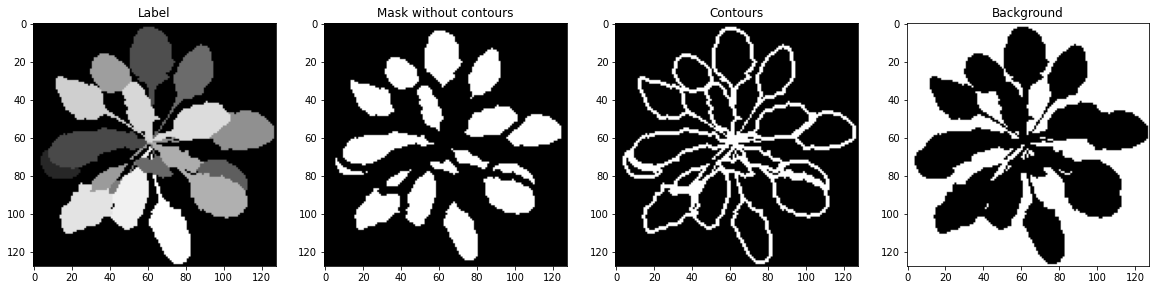

In [ ]:
y_train = np.zeros([IMG_WIDTH, IMG_HEIGHT, LABEL_CHANNELS])

y_train[:,:,1]  = np.logical_and(mask, contour_gr(label))
y_train[:,:,0]  = np.logical_and(mask, np.logical_not(y_train[:,:,1]))
y_train[:,:,2]  = background(y_train[:,:,1]  + y_train[:,:,0] )

show_images(images = [label, y_train[:,:,0] , y_train[:,:,1] , y_train[:,:,2] ],
            titles = ['Label', 'Mask without contours', 'Contours', 'Background'])

## **Reading train and test data from pickle files**

###CVPPP RGB dataset

In [ ]:
# Loading training data CVPPP_RGB and lables from pickle file
pickle_in = open(TRAIN_PATH + "/X_train_RGB.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open(TRAIN_PATH + "/Y_train_RGB.pickle","rb")
Y_train = pickle.load(pickle_in)

### Test dataset: Real Fluo

In [ ]:
# Loading training data and lables from pickle file
pickle_in = open(TEST_PATH+"/X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open(TEST_PATH+"/Y_test.pickle","rb")
Y_test = pickle.load(pickle_in)

In [ ]:
print("Total number of examples: ", len(X_train))
print("Number of test examples: ", len(X_test))

Total number of examples:  783
Number of test examples:  38


### Data preprocessing: converting RGB images to gray-scale 

In [ ]:
for ix in range(X_train.shape[0]):
  X_train[ix] = rgb_to_gray(X_train[ix])

### Checking X_train/Y_train and X_test/Y_test examples

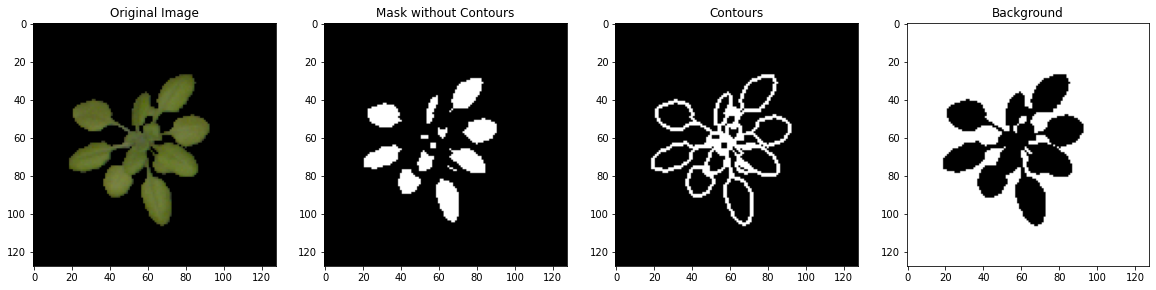

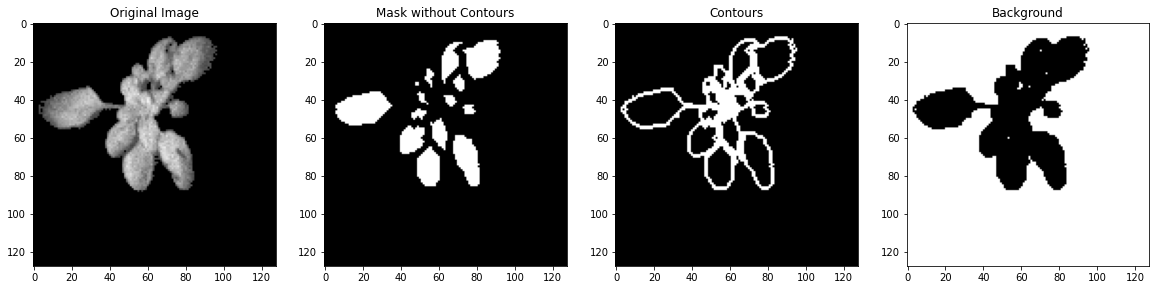

In [ ]:
ix = random.randint(0, len(X_train)-1)
show_images(images = [X_train[ix],Y_train[ix,:,:,0], Y_train[ix,:,:,1],Y_train[ix,:,:,2]],
            titles = ['Original Image', 'Mask without Contours', 'Contours', 'Background'])
ix = random.randint(0, len(X_test)-1)
show_images(images = [X_test[ix],Y_test[ix,:,:,0], Y_test[ix,:,:,1], Y_test[ix,:,:,2]],
            titles = ['Original Image', 'Mask without Contours', 'Contours', 'Background'])

# **STEP 1: Multi-class segmentation with U-Net model: familiarization with the "Segmentation models" library**

Here we use the Python library with Neural Networks for Image Segmentation based on Keras and TensorFlow created by Pavel Yakubovskiy from Skoltech, Moscow: [Segmentation models](https://github.com/qubvel/segmentation_models#examples). The library allows to set the model and its training in a few code lines.

## TASK: Train the base model, note its performance and the quality of fitting. We will use it as a reference performance for further benchmarking.

### Set up segmentation_models library

In [ ]:
!pip install -U segmentation-models

     |████████████████████████████████| 51kB 6.2MB/s 


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
#import library
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


## **Model setup**

#### Model parameters

Here we set parameters determining model architecture. "Backbone" determines a model encoder. Let us use "vgg16" architecture as encoder. Don't forget that every image pixel should be classified in three classes, n_classes = 3. And in multi-class classification we use "softmax" activation function. Moreover, we will start training not with random but with pre-trained weights on "imagenet" dataset.    

In [ ]:
BACKBONE = 'vgg16'
n_classes = 3
activation = 'softmax'
weights = 'imagenet'

In [ ]:
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=weights, classes = n_classes, activation=activation)

58892288/58889256 [==============================] - 1s 0us/step


### Training parameters

In [ ]:
from keras.losses import categorical_crossentropy

def dice_coef(y_true, y_pred, smooth=1e-3):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return K.mean((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [ ]:
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 100
OPTIMIZER = tf.keras.optimizers.Adam(LR)
custom_loss = sm.losses.CategoricalCELoss()
#metric = sm.metrics.IOUScore
metric = dice_coef

In [ ]:
# Model compilation
model.compile(optimizer =OPTIMIZER, loss = custom_loss, metrics=[metric])

In [ ]:
Y_train = Y_train * 1.0

## **Model training**

In [ ]:
# Train model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_VGG16_RGB.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[earlystopper, checkpointer])

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.0173 - dice_coef: 0.9868
Epoch 00001: val_loss improved from inf to 0.16076, saving model to UNET_VGG16_RGB.h5
40/40 [==============================] - 7s 187ms/step - loss: 0.0173 - dice_coef: 0.9868 - val_loss: 0.1608 - val_dice_coef: 0.9201
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.0162 - dice_coef: 0.9877
Epoch 00002: val_loss did not improve from 0.16076
40/40 [==============================] - 7s 166ms/step - loss: 0.0162 - dice_coef: 0.9877 - val_loss: 0.1685 - val_dice_coef: 0.9219
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.0149 - dice_coef: 0.9888
Epoch 00003: val_loss did not improve from 0.16076
40/40 [==============================] - 7s 166ms/step - loss: 0.0149 - dice_coef: 0.9888 - val_loss: 0.1626 - val_dice_coef: 0.9212
Epoch 4/100
40/40 [==============================] - ETA: 0s - loss: 0.0138 - dice_coef: 0.9897
Epoch 00004: val_loss improve

## **Make predictions**

Let's make predictions both on the test set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [ ]:
# load model
model = load_model('UNET_VGG16_RGB.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

20/20 - 1s
2/2 - 0s


In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
# Evaluating the trained model
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 12ms/step - loss: 0.1525 - dice_coef: 0.9200


In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

Train Loss = 0.044959574937820435
Train Dice_coef = 0.9689260721206665
Test Loss = 0.15251301229000092
Test Dice_coef = 0.919980525970459


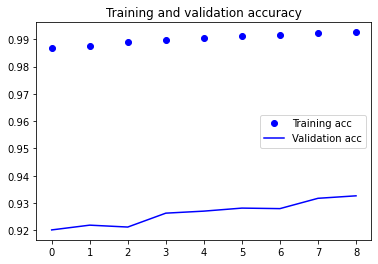

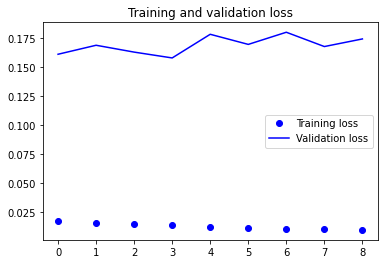

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

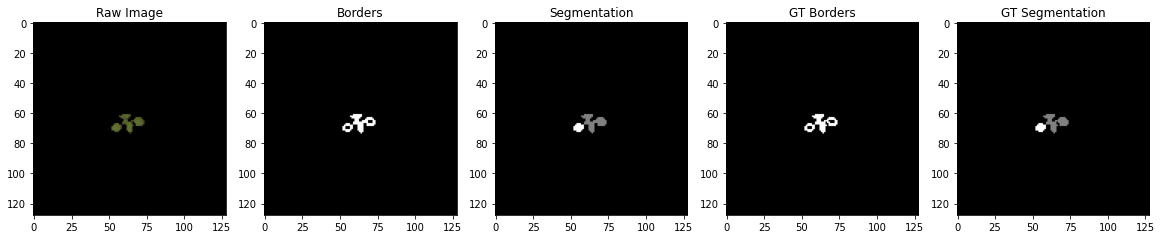

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

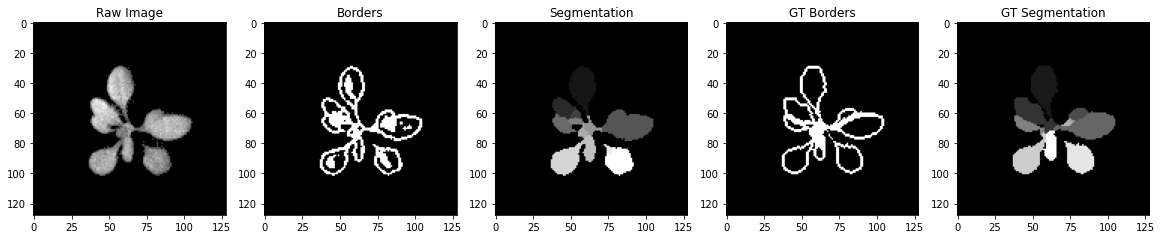

In [ ]:
ix = random.randint(0, len(preds_test))
show_images(images = [X_test[ix], 
                      preds_test_t[ix,:,:,1], 
                      label_watershed(1-preds_test_t[ix,:,:,2],preds_test_t[ix,:,:,0]), 
                      Y_test[ix,:,:,1],
                      label_watershed(1-Y_test[ix,:,:,2],Y_test[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **STEP 2: Using gray scale images instead of RGB**


### After convertion of train images into gray-scale, train and test images will have the same color scheme. Let us see if it can improve model performance on test images.

##TASK: convert RGB images into gray-scale with use of function *rgb_to_gray(img)*, train model and compare its performance with the previous case. What we can conclude?

## **Data preprocessing: converting RGB images into gray-scale** 

In [ ]:
for ix in range(X_train.shape[0]):
  X_train[ix] = rgb_to_gray(X_train[ix])

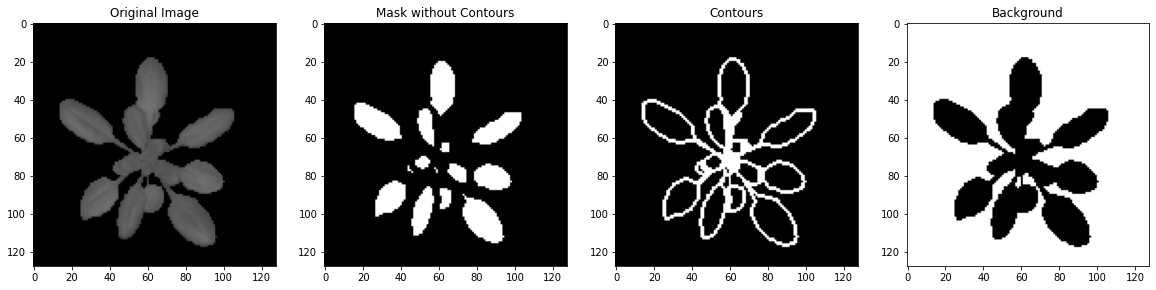

In [ ]:
ix = random.randint(0, len(X_train)-1)
show_images(images = [X_train[ix],Y_train[ix,:,:,0], Y_train[ix,:,:,1],Y_train[ix,:,:,2]],
            titles = ['Original Image', 'Mask without Contours', 'Contours', 'Background'])

## **Model setup**

#### Model parameters

In [ ]:
BACKBONE = 'vgg16'
n_classes = 3
activation = 'softmax'
weights = 'imagenet'

In [ ]:
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=weights, classes = n_classes, activation=activation)

### Training parameters

In [ ]:
from keras.losses import categorical_crossentropy

def dice_coef(y_true, y_pred, smooth=1e-3):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return K.mean((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [ ]:
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 100
OPTIMIZER = tf.keras.optimizers.Adam(LR)
custom_loss = sm.losses.CategoricalCELoss()
#metric = sm.metrics.IOUScore
metric = dice_coef

In [ ]:
# Model compilation
model.compile(optimizer =OPTIMIZER, loss = custom_loss, metrics=[metric])

In [ ]:
Y_train = Y_train * 1.0

## **Model training**

In [ ]:
# Train model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_VGG16_GS.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[earlystopper, checkpointer])

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.2275 - dice_coef: 0.5365WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0055s vs `on_test_batch_end` time: 0.0370s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.33328, saving model to UNET_VGG16_GS.h5
40/40 [==============================] - 8s 192ms/step - loss: 0.2275 - dice_coef: 0.5365 - val_loss: 0.3333 - val_dice_coef: 0.4291
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.1366 - dice_coef: 0.6781
Epoch 00002: val_loss improved from 0.33328 to 0.27916, saving model to UNET_VGG16_GS.h5
40/40 [==============================] - 7s 187ms/step - loss: 0.1366 - dice_coef: 0.6781 - val_loss: 0.2792 - val_dice_coef: 0.4902
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.0933 - dice_coef: 0.7662
Epoch 00003: val_loss improved from 0.27916 to 0.19066, saving model to UNET_VGG16_GS.h5
40/40 [===

## **Make predictions**

Let's make predictions both on the test set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [ ]:
# load model
model = load_model('UNET_VGG16_GS.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

20/20 - 1s
2/2 - 0s


In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
# Evaluating the trained model
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 13ms/step - loss: 0.1240 - dice_coef: 0.9404


In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

Train Loss = 0.04247219115495682
Train Dice_coef = 0.9688785076141357
Test Loss = 0.12399367243051529
Test Dice_coef = 0.9403798580169678


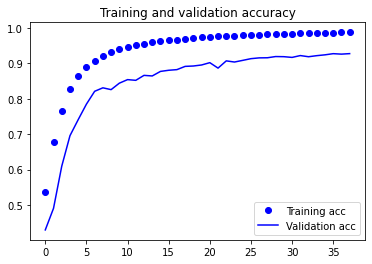

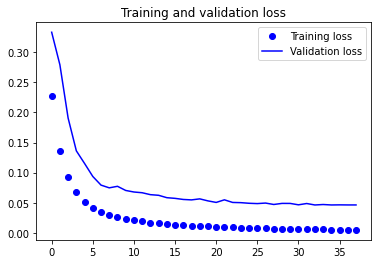

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

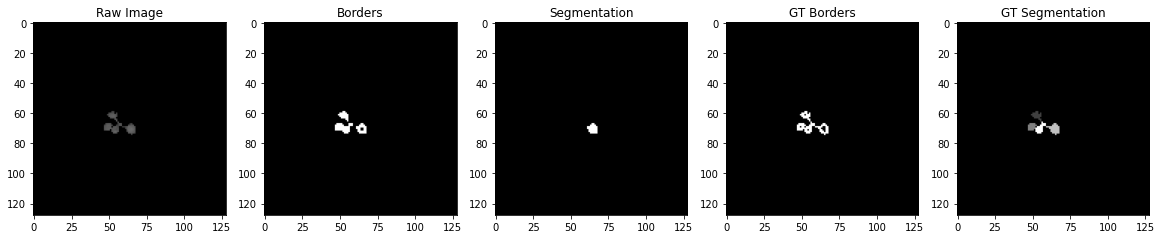

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

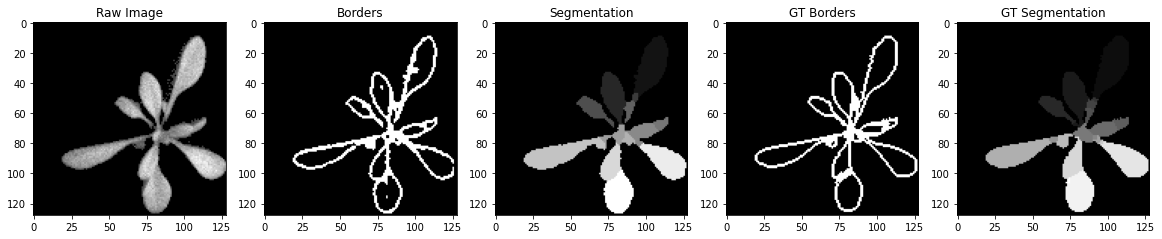

In [ ]:
ix = random.randint(0, len(preds_test))
show_images(images = [X_test[ix], 
                      preds_test_t[ix,:,:,1], 
                      label_watershed(1-preds_test_t[ix,:,:,2],preds_test_t[ix,:,:,0]), 
                      Y_test[ix,:,:,1],
                      label_watershed(1-Y_test[ix,:,:,2],Y_test[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **STEP 3: Using data augmentation with "Albumentation" library**

### You can explore image augmentation libarary by using this link [Albumentation](https://github.com/albumentations-team/albumentations).

## TASK: to analyse what type of augmentation can increase the model performance

## **Setup data augmentation**

In [ ]:
aug_proportion = 0.8
n_aug = int(len(X_train) * aug_proportion)
X_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.bool)

aug = Compose([HorizontalFlip(p=1),
               RandomBrightness(p=1.2, limit=0.2),
               RandomContrast(p=0.2, limit=0.2)
            ])
augmented = aug(image=X_train[0:n_aug,:,:,:], mask=Y_train[0:n_aug,:,:,:])

X_aug = augmented['image']
Y_aug = augmented['mask']
print(X_aug.shape, Y_aug.shape)

(626, 128, 128, 3) (626, 128, 128, 3)


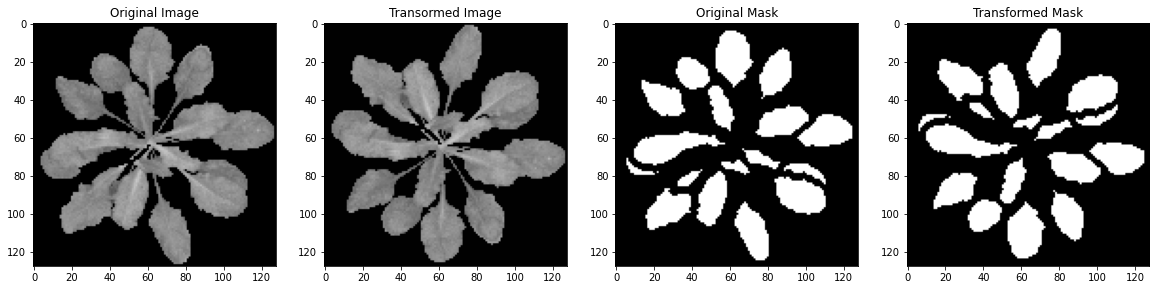

In [ ]:
ix = random.randint(0, len(X_aug))
show_images(images = [X_train[ix], X_aug[ix], Y_train[ix,:,:,0],  Y_aug[ix,:,:,0]],
            titles = ['Original Image', 'Transormed Image', 'Original Mask', 'Transformed Mask'])

In [ ]:
# Train data + Albumentations
X_train = np.append(X_train, X_aug, axis=0)
Y_train = np.append(Y_train, Y_aug, axis=0)
idx = np.random.permutation(len(X_train))
X_train, Y_train = X_train[idx], Y_train[idx]

## **Model setup**

#### Model parameters

In [ ]:
BACKBONE = 'vgg16'
CLASSES = 3
ACTIVATION = 'softmax'
WEIGHTS = 'imagenet'

In [ ]:
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=WEIGHTS, classes=CLASSES, activation=ACTIVATION)

### Training parameters

In [ ]:
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 100
OPTIMIZER = tf.keras.optimizers.Adam(LR)
custom_loss = sm.losses.CategoricalCELoss()
metric = dice_coef

In [ ]:
# Model compilation
model.compile(optimizer =OPTIMIZER, loss = custom_loss, metrics=[metric])

## **Model training**

In [ ]:
# Train model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_VGG16_augm.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[earlystopper, checkpointer])

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.1691 - dice_coef: 0.6674WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0052s vs `on_test_batch_end` time: 0.0376s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.20707, saving model to UNET_VGG16_augm.h5
71/71 [==============================] - 16s 226ms/step - loss: 0.1691 - dice_coef: 0.6674 - val_loss: 0.2071 - val_dice_coef: 0.5650
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.0751 - dice_coef: 0.8300
Epoch 00002: val_loss did not improve from 0.20707
71/71 [==============================] - 12s 168ms/step - loss: 0.0751 - dice_coef: 0.8300 - val_loss: 0.2079 - val_dice_coef: 0.5701
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.0524 - dice_coef: 0.8811
Epoch 00003: val_loss improved from 0.20707 to 0.10309, saving model to UNET_VGG16_augm.h5
71/71 [==============================] - 1

## **Make predictions**

In [ ]:
# load model
model = load_model('UNET_VGG16_augm.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

36/36 - 3s
2/2 - 0s


In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
#preds_test_t1 = (preds_test > 0.9).astype(np.uint8)

In [ ]:
# Evaluating the trained model
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 13ms/step - loss: 0.1425 - dice_coef: 0.9517


In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

Train Loss = 0.012901673093438148
Train Dice_coef = 0.9914543032646179
Test Loss = 0.14254425466060638
Test Dice_coef = 0.9516514539718628


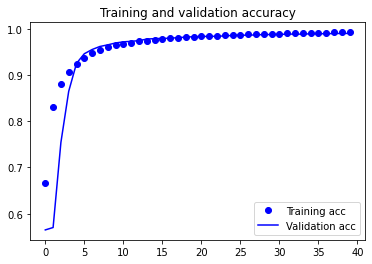

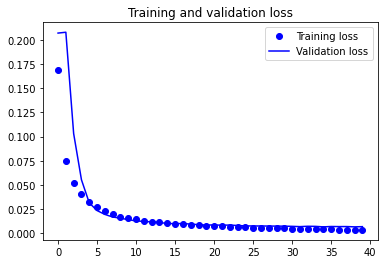

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

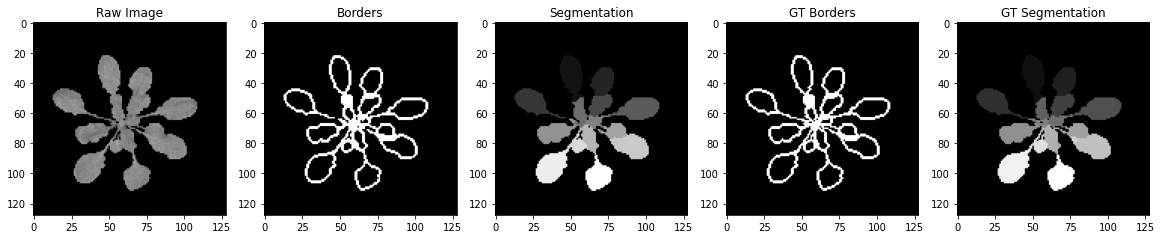

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

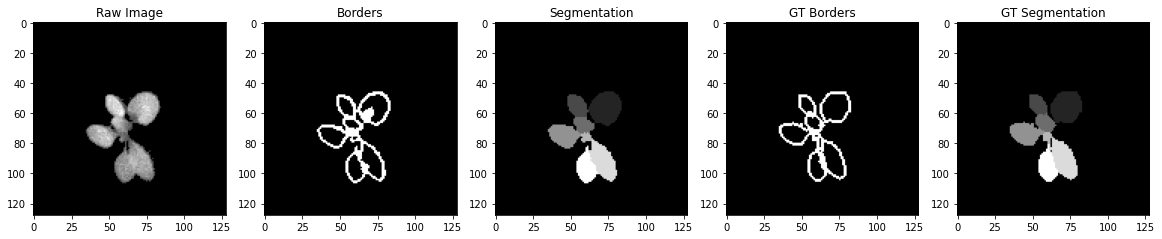

In [ ]:
ix = random.randint(0, len(preds_test))
show_images(images = [X_test[ix], 
                      preds_test_t[ix,:,:,1], 
                      label_watershed(1-preds_test_t[ix,:,:,2],preds_test_t[ix,:,:,0]), 
                      Y_test[ix,:,:,1],
                      label_watershed(1-Y_test[ix,:,:,2],Y_test[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **STEP 4: The role of loss function: weighted loss**

### With custom loss function we can solve the problem of imbalanced classes. 

## TASK: Replace "categorical_crossentropy" with "weighted_cce_dice" in order to balance classes. Train the model again and compare model performance with the previous situation.

## **Model setup**

#### Model parameters

In [ ]:
BACKBONE = 'vgg16'
CLASSES = 3
ACTIVATION = 'softmax'
WEIGHTS = 'imagenet'

In [ ]:
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=WEIGHTS, classes=CLASSES, activation=ACTIVATION)

### Training parameters

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def weighted_cce_dice(weights):
  '''
  weight[0] = cce_w = 0.6
  weight[1] = border_w = 0.2
  weight[2] = mask_w = 0.2
  loss = 0.6*cce + 0.2*soft_dice_loss(mask) + 0.2*soft_dice_loss(border)
  '''
  
  weights = K.variable(weights)
  
  def loss(y_true, y_pred):
    return weights[0]*categorical_crossentropy(y_true, y_pred) + weights[1]*dice_coef_loss(y_true[..., 0], y_pred[..., 0]) + weights[2]*dice_coef_loss(y_true[..., 1], y_pred[..., 1]) 

  return loss

In [ ]:
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 100
OPTIMIZER = tf.keras.optimizers.Adam(LR)
custom_loss = weighted_cce_dice([0.4, 0.5, 0.1])
metric = dice_coef

In [ ]:
# Model compilation
model.compile(optimizer =OPTIMIZER, loss = custom_loss, metrics=[metric])

## **Model training**

In [ ]:
# Train model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_VGG16_weightedLoss.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[earlystopper, checkpointer])

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.6295 - dice_coef: 0.6264
Epoch 00001: val_loss improved from inf to 1.30577, saving model to UNET_VGG16_weightedLoss.h5
67/67 [==============================] - 10s 153ms/step - loss: 0.6295 - dice_coef: 0.6264 - val_loss: 1.3058 - val_dice_coef: 0.2190
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.4024 - dice_coef: 0.8112
Epoch 00002: val_loss improved from 1.30577 to 0.64406, saving model to UNET_VGG16_weightedLoss.h5
67/67 [==============================] - 10s 148ms/step - loss: 0.4024 - dice_coef: 0.8112 - val_loss: 0.6441 - val_dice_coef: 0.6246
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.2926 - dice_coef: 0.8833
Epoch 00003: val_loss improved from 0.64406 to 0.35752, saving model to UNET_VGG16_weightedLoss.h5
67/67 [==============================] - 10s 149ms/step - loss: 0.2926 - dice_coef: 0.8833 - val_loss: 0.3575 - val_dice_coef: 0.8552
Epoch 4/100
67/67

## **Make predictions**

In [ ]:
# load model
model = load_model('UNET_VGG16_weightedLoss.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

34/34 - 2s
2/2 - 0s


In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
#preds_test_t1 = (preds_test > 0.9).astype(np.uint8)

In [ ]:
# Evaluating the trained model
Y_test = Y_test * 1.0
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 11ms/step - loss: 0.1809 - dice_coef: 0.9534


In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

Train Loss = 0.0178026482462883
Train Dice_coef = 0.9956221580505371
Test Loss = 0.18091285228729248
Test Dice_coef = 0.9534308314323425


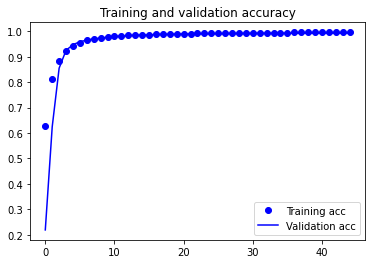

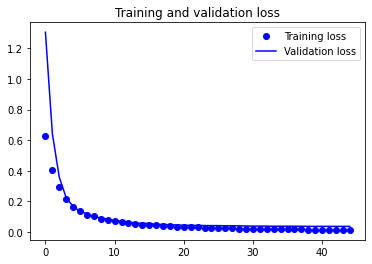

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

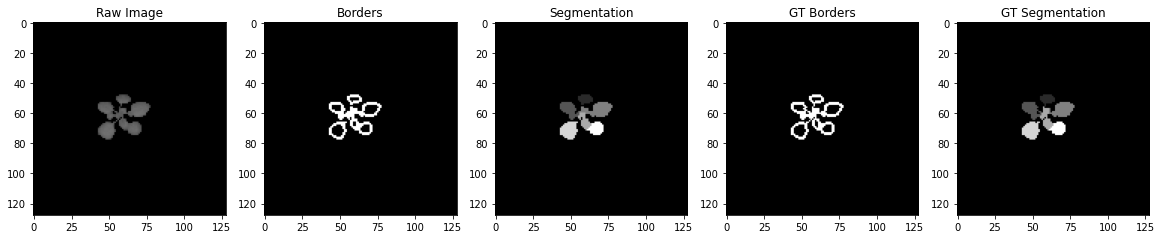

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

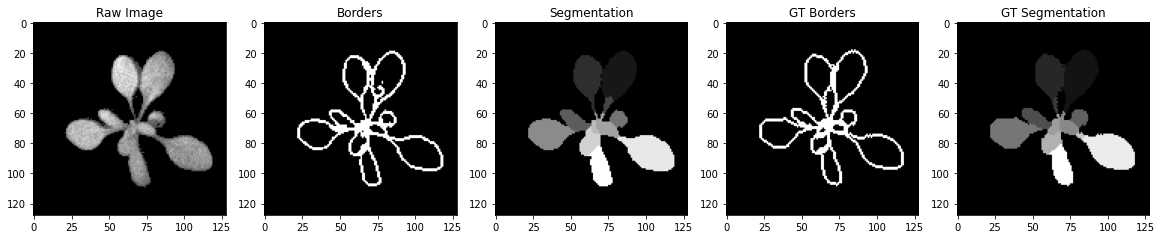

In [ ]:
ix = random.randint(0, len(preds_test))
show_images(images = [X_test[ix], 
                      preds_test_t[ix,:,:,1], 
                      label_watershed(1-preds_test_t[ix,:,:,2],preds_test_t[ix,:,:,0]), 
                      Y_test[ix,:,:,1],
                      label_watershed(1-Y_test[ix,:,:,2],Y_test[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **STEP 5: The role of encoder architecture**

###Here we set parameters determining model architecture. "Backbone" determines a model encoder.   

## TASK: Let's go deeper! Change the backbone to "resnet152", train the model and analyse the impact of the encoder architecture on the model performance. 

## **Model setup**

#### Model parameters

In [ ]:
BACKBONE = 'resnet152'
CLASSES = 3
ACTIVATION = 'softmax'
WEIGHTS = 'imagenet'

In [ ]:
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=WEIGHTS, classes=CLASSES, activation=ACTIVATION)

234332160/234326024 [==============================] - 6s 0us/step


### Training parameters

In [ ]:
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 100
OPTIMIZER = tf.keras.optimizers.Adam(LR)
custom_loss = weighted_cce_dice([0.4, 0.5, 0.1])
metric=dice_coef

In [ ]:
# Model compilation
model.compile(optimizer =OPTIMIZER, loss = custom_loss, metrics=[metric])

## **Model training**

In [ ]:
# Train model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_RESNET152_augm.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[earlystopper, checkpointer])

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.8017 - dice_coef: 0.4855
Epoch 00001: val_loss improved from inf to 0.82583, saving model to UNET_RESNET152_augm.h5
67/67 [==============================] - 22s 322ms/step - loss: 0.8017 - dice_coef: 0.4855 - val_loss: 0.8258 - val_dice_coef: 0.5400
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.5369 - dice_coef: 0.7041
Epoch 00002: val_loss improved from 0.82583 to 0.76477, saving model to UNET_RESNET152_augm.h5
67/67 [==============================] - 20s 292ms/step - loss: 0.5369 - dice_coef: 0.7041 - val_loss: 0.7648 - val_dice_coef: 0.6777
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.3790 - dice_coef: 0.8256
Epoch 00003: val_loss improved from 0.76477 to 0.75435, saving model to UNET_RESNET152_augm.h5
67/67 [==============================] - 20s 297ms/step - loss: 0.3790 - dice_coef: 0.8256 - val_loss: 0.7544 - val_dice_coef: 0.7525
Epoch 4/100
67/67 [==========

## **Make predictions**

In [ ]:
# load model
model = load_model('UNET_RESNET152_augm.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

34/34 - 3s
2/2 - 0s


In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
#preds_test_t1 = (preds_test > 0.9).astype(np.uint8)

In [ ]:
# Evaluating the trained model
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 22ms/step - loss: 0.1938 - dice_coef: 0.9550


In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

Train Loss = 0.01647898182272911
Train Dice_coef = 0.9967325329780579
Test Loss = 0.1938355416059494
Test Dice_coef = 0.9549705982208252


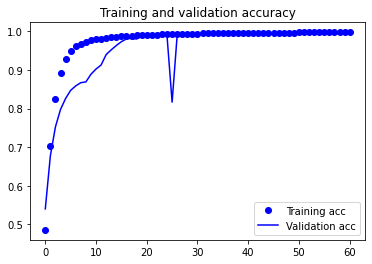

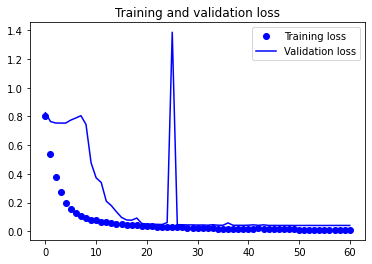

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

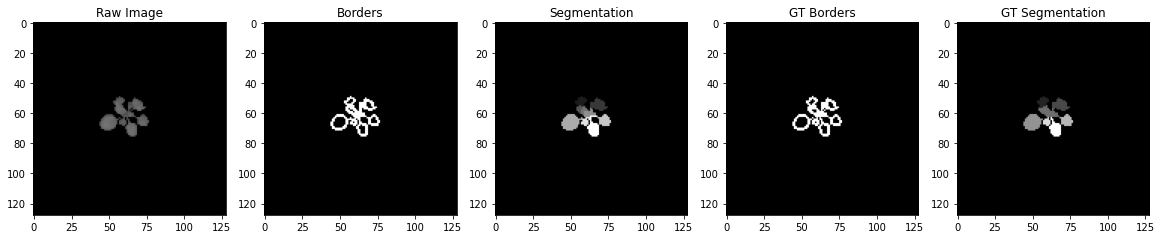

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

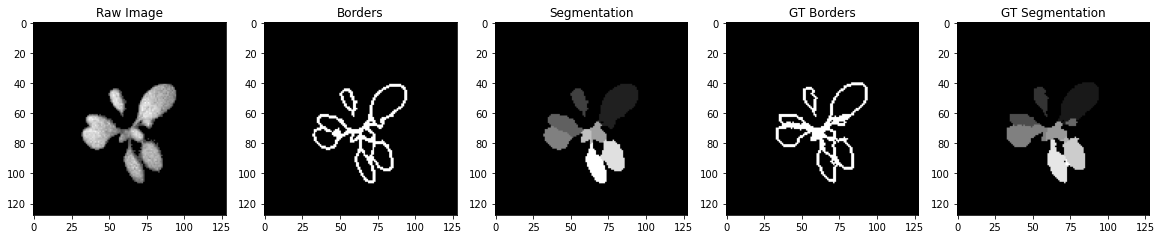

In [ ]:
ix = random.randint(0, len(preds_test))
show_images(images = [X_test[ix], 
                      preds_test_t[ix,:,:,1], 
                      label_watershed(1-preds_test_t[ix,:,:,2],preds_test_t[ix,:,:,0]), 
                      Y_test[ix,:,:,1],
                      label_watershed(1-Y_test[ix,:,:,2],Y_test[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **New dataset: let us include some real fluorescent images in training dataset**

### Combined dataset: X_train + X_test 10 ex

In [ ]:
X_train = np.append(X_train, X_test[0:10], axis=0)
Y_train = np.append(Y_train, Y_test[0:10], axis=0)
idx = np.random.permutation(len(X_train))
X_train, Y_train = X_train[idx], Y_train[idx]

In [ ]:
X_test = X_test[10:]
Y_test = Y_test[10:]

# **STEP 6: Model fine tuning: classifier training**

## TASK: Train the classifier on the new dataset and compare the model performance with the previous case. 

In [ ]:
#Freeze all layers excluding classifier
for i in range(len(model.layers)-1):
    model.layers[i].trainable = False

In [ ]:
model.compile(optimizer ='adam', loss = custom_loss, metrics=[dice_coef])
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_18[0][0]          
______________________________________________________________________________________

In [ ]:
# train model with 27 trainable parameters on a new dataset
earlystopper = EarlyStopping(patience=5, verbose=0)
checkpointer = ModelCheckpoint('UNET_finetuning_classifier.h5', verbose=0, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=100, callbacks=[earlystopper, checkpointer])

Epoch 1/100
67/67 [==============================] - 9s 139ms/step - loss: 0.0176 - dice_coef: 0.9966 - val_loss: 0.0158 - val_dice_coef: 0.9968
Epoch 2/100
67/67 [==============================] - 5s 76ms/step - loss: 0.0179 - dice_coef: 0.9966 - val_loss: 0.0158 - val_dice_coef: 0.9968
Epoch 3/100
67/67 [==============================] - 5s 76ms/step - loss: 0.0172 - dice_coef: 0.9966 - val_loss: 0.0158 - val_dice_coef: 0.9968
Epoch 4/100
67/67 [==============================] - 5s 76ms/step - loss: 0.0176 - dice_coef: 0.9966 - val_loss: 0.0158 - val_dice_coef: 0.9968
Epoch 5/100
67/67 [==============================] - 5s 76ms/step - loss: 0.0176 - dice_coef: 0.9966 - val_loss: 0.0158 - val_dice_coef: 0.9968
Epoch 6/100
67/67 [==============================] - 5s 77ms/step - loss: 0.0174 - dice_coef: 0.9966 - val_loss: 0.0158 - val_dice_coef: 0.9968


## **Make predictions**

In [ ]:
# load model
model = load_model('UNET_finetuning_classifier.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

34/34 - 3s
1/1 - 0s


In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
#preds_test_t1 = (preds_test > 0.9).astype(np.uint8)

In [ ]:
# Evaluating the trained model
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.2069 - dice_coef: 0.9638


In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

Train Loss = 0.017330219969153404
Train Dice_coef = 0.9966750144958496
Test Loss = 0.20692065358161926
Test Dice_coef = 0.9638243317604065


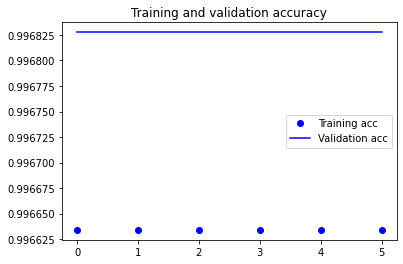

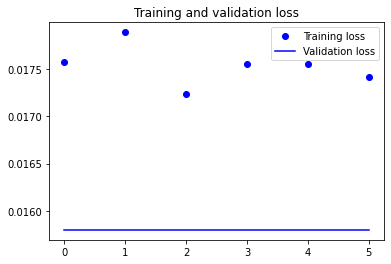

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

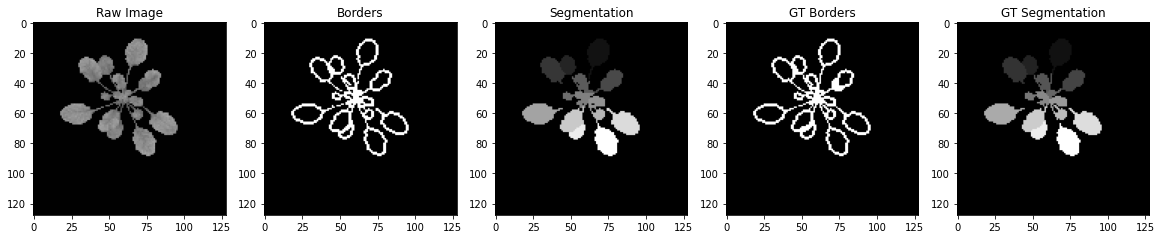

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

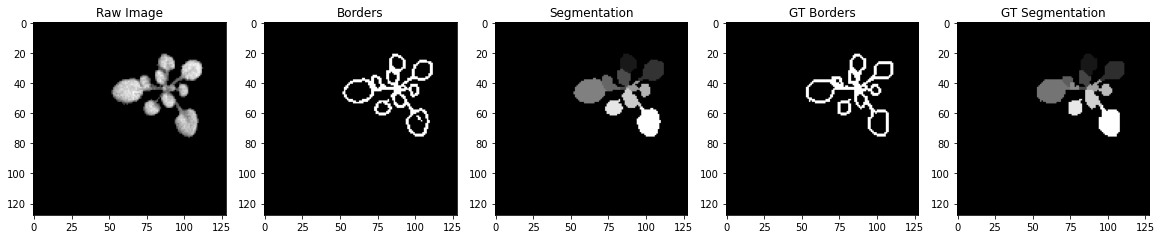

In [ ]:
ix = random.randint(0, len(preds_test))
show_images(images = [X_test[ix], 
                      preds_test_t[ix,:,:,1], 
                      label_watershed(1-preds_test_t[ix,:,:,2],preds_test_t[ix,:,:,0]), 
                      Y_test[ix,:,:,1],
                      label_watershed(1-Y_test[ix,:,:,2],Y_test[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **STEP 7: Model fine tuning: training classifier + two last layers**  

## TASK: Train the classifier and two last layers on the new dataset and compare the model performance with the previous case. 

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
#Freeze all layers excluding last two layers + classifier
for i in range(len(model.layers)-5):
    model.layers[i].trainable = False

In [ ]:
model.compile(optimizer ='adam', loss = custom_loss, metrics=[dice_coef])
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_18[0][0]          
______________________________________________________________________________________

In [ ]:
# train model with all trainable parameters on a new dataset
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_finetuning_classifier_twolayers.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=100, callbacks=[earlystopper, checkpointer])

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.0183 - dice_coef: 0.9965
Epoch 00001: val_loss improved from inf to 0.01510, saving model to UNET_finetuning_classifier_twolayers.h5
67/67 [==============================] - 9s 138ms/step - loss: 0.0183 - dice_coef: 0.9965 - val_loss: 0.0151 - val_dice_coef: 0.9971
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.0172 - dice_coef: 0.9968
Epoch 00002: val_loss improved from 0.01510 to 0.01497, saving model to UNET_finetuning_classifier_twolayers.h5
67/67 [==============================] - 7s 105ms/step - loss: 0.0172 - dice_coef: 0.9968 - val_loss: 0.0150 - val_dice_coef: 0.9972
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.0165 - dice_coef: 0.9969
Epoch 00003: val_loss did not improve from 0.01497
67/67 [==============================] - 6s 83ms/step - loss: 0.0165 - dice_coef: 0.9969 - val_loss: 0.0153 - val_dice_coef: 0.9972
Epoch 4/100
67/67 [========================

## **Make predictions**

In [ ]:
# load model
model = load_model('UNET_finetuning_classifier_twolayers.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

34/34 - 3s
1/1 - 0s


In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
#preds_test_t1 = (preds_test > 0.9).astype(np.uint8)

In [ ]:
# Evaluating the trained model
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.2286 - dice_coef: 0.9640


In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

Train Loss = 0.014483053237199783
Train Dice_coef = 0.9975098967552185
Test Loss = 0.22862033545970917
Test Dice_coef = 0.9639649987220764


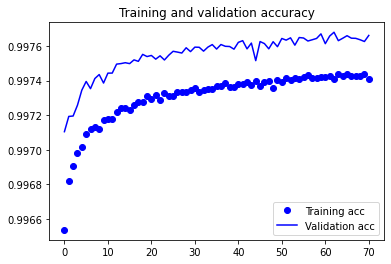

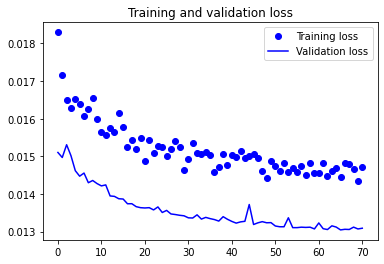

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

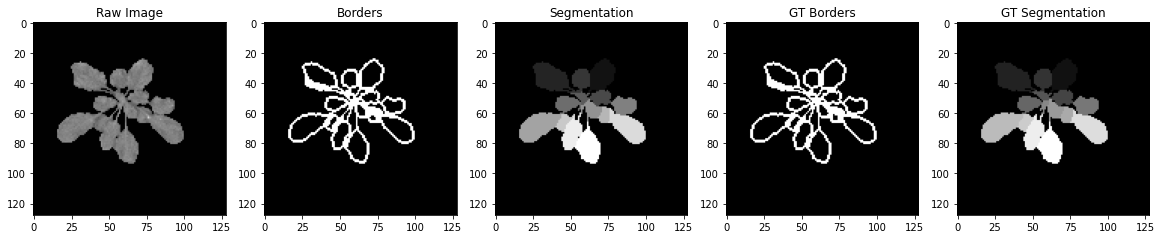

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

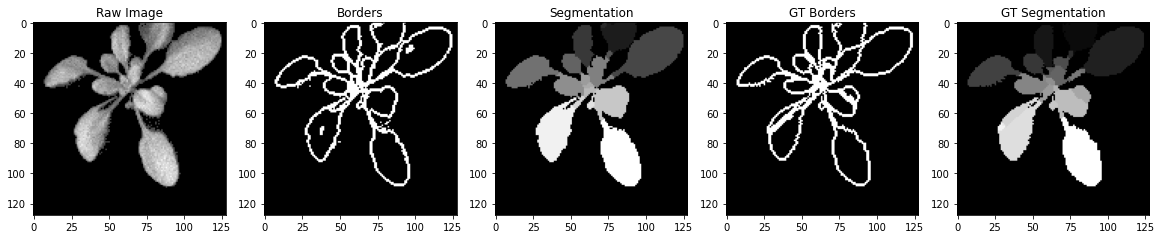

In [ ]:
ix = random.randint(0, len(preds_test))
show_images(images = [X_test[ix], 
                      preds_test_t[ix,:,:,1], 
                      label_watershed(1-preds_test_t[ix,:,:,2],preds_test_t[ix,:,:,0]), 
                      Y_test[ix,:,:,1],
                      label_watershed(1-Y_test[ix,:,:,2],Y_test[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **STEP 8: Model fine tuning: training only randomly initialized decoder** 

Some times, it is useful to train only randomly initialized decoder in order not to damage weights of properly trained encoder with huge gradients during first steps of training. In this case, all you need is just pass freeze_encoder = True argument while initializing the model.

## TASK: Train the decoder on the new dataset and compare the model performance with the previous case. 

In [ ]:
#Useful trick
#Freeze encoder weights for fine-tuning during first epochs of training:
from segmentation_models.utils import set_trainable

model = sm.Unet(backbone_name='resnet152', encoder_weights='imagenet', classes=3, activation='softmax', encoder_freeze=True)
custom_loss = sm.losses.CategoricalCELoss()
model.compile(optimizer ='adam', loss = custom_loss, metrics=[dice_coef])

# pretrain model decoder
model.fit(X_train, Y_train, epochs=2)

Epoch 1/2
42/42 [==============================] - 12s 275ms/step - loss: 0.1209 - dice_coef: 0.7512
Epoch 2/2
42/42 [==============================] - 12s 279ms/step - loss: 0.0310 - dice_coef: 0.9314


In [ ]:
# release all layers for training
set_trainable(model) # set all layers trainable and recompile model

AttributeError: ignored

In [ ]:
model.summary()

In [ ]:
# continue training
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_finetuning_decoder.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=100, callbacks=[earlystopper, checkpointer])

## **Make predictions**

In [ ]:
# load model
model = load_model('UNET_finetuning_decoder.h5', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

In [ ]:
# Predict on train and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=2)
preds_test = model.predict(X_test, verbose=2)

In [ ]:
# Threshold predictions
preds_test_t = np.zeros((Y_test.shape[0], IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)
preds_train_t = np.zeros((int(X_train.shape[0]*0.8), IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.integer)

for k in range(Y_test.shape[0]):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):         
            preds_test_t[k,i,j,np.argmax(preds_test[k,i,j,:])] = 1


for k in range(int(X_train.shape[0]*0.8)):
    for i in range(IMG_HEIGHT):
        for j in range(IMG_WIDTH):
            preds_train_t[k,i,j,np.argmax(preds_train[k,i,j,:])] = 1

In [ ]:
#preds_test_t1 = (preds_test > 0.9).astype(np.uint8)

In [ ]:
# Evaluating the trained model
eval_train = model.evaluate(X_train, Y_train)
eval_test = model.evaluate(X_test, Y_test)

In [ ]:
print("Train Loss = " + str(eval_train[0]))
print("Train Dice_coef = " + str(eval_train[1]))
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
ix = random.randint(0, len(preds_train))
show_images(images = [X_train[ix], 
                      preds_train_t[ix,:,:,1], 
                      label_watershed(1-preds_train_t[ix,:,:,2],preds_train_t[ix,:,:,0]), 
                      Y_train[ix,:,:,1],
                      label_watershed(1-Y_train[ix,:,:,2],Y_train[ix,:,:,0])],
            titles = ['Raw Image', 'Borders', 'Segmentation', 'GT Borders', 'GT Segmentation'])

# **STEP 9: Training from scratch**

### Now you are enough experienced to code the model setup and its training by yourself. Analyse what worked well and code U-Net training on the new dataset from scratch. 